# Topic Modeling
### Find Topic Proportion for each review text

In [25]:
import warnings
warnings.filterwarnings('ignore')

import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pattern.en import lemma

import nltk
from nltk.corpus import stopwords

from pprint import pprint

In [26]:
reviews = pd.read_csv('data/reviews2.csv')
users = pd.read_csv('data/users2.csv')
restaurants = pd.read_csv("data/restaurants2.csv")
print("reviews shape:  ", reviews.shape)

reviews shape:   (1707861, 9)


In [104]:
selected_user_id = users['user_id'].sample(n=500, random_state = 48)
selected_business_id = restaurants['business_id'].sample(n=1500, random_state = 48)

In [105]:
selected_reviews = reviews[(reviews['user_id'].isin(selected_user_id)) &\
                           (reviews['business_id'].isin(selected_business_id))]
print("Selected reviews count:  ", selected_reviews.shape)

comment2 = selected_reviews['text'].to_frame().copy().reset_index(drop=True)

Selected reviews count:   (32984, 9)


### Preliminary Text Pre-processing
- remove special characters
- convert to lower case
- remove stop words

In [106]:
word_count = sorted(Counter(" ".join(comment2['text'].to_list()).lower().split()).items(), key = lambda x: x[1], reverse=True)
oq, lq = np.quantile([i[1] for i in word_count], [0.05, 0.999])
removed_words = [i[0] for i in word_count if i[1] <= 1 or i[1] >= lq]
print("Remove criterion:  {} < wordcount < {}".format(oq, lq))
print("Total words:  {},  Removed words:  {}".format(len(word_count), len(removed_words)))
# plt.plot(np.arange(0, 1, 0.001), np.quantile([i[1] for i in word_count], np.arange(0, 1, 0.001)))

Remove criterion:  1.0 < wordcount < 4056.816999999428
Total words:  169698,  Removed words:  101429


In [107]:
stop_words = stopwords.words("english")
stop_words.extend(['use','food','good','place', 'great', 'like', 'really', 'get', 'eat', 
                   'come', 'also', 'go', 'time', 'order', 'restaurant', 'make', 'one', 'side',
                  'take', 'taste'])
stop_words.extend(removed_words)
stop_words = set(stop_words)

In [108]:
## Remove special characters
comment2['text_processed'] = comment2['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# lowercases, tokenizes, de-accents 
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
comment2['text_processed'] = list(sent_to_words(comment2['text_processed']))
print("Gensim Preprocessed Done")

# Remove stopwords
%timeit comment2['text_processed'] = comment2['text_processed'].apply(lambda x: [w for w in x if w not in stop_words])
print("Removed stopwords done")

# Lemmatize
comment2['text_processed'] = comment2['text_processed'].apply(lambda x: [lemma(w) for w in x])
print("Lemmatized Done")

# Remove stopwords
%timeit comment2['text_processed'] = comment2['text_processed'].apply(lambda x: [w for w in x if w not in stop_words])
print("Removed stopwords done")

Gensim Preprocessed Done
173 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Removed stopwords done
Lemmatized Done
126 ms ± 946 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Removed stopwords done


In [109]:
print('Original: ', comment2.iloc[1]['text'], '\n')
print('Preprocessed:  ', comment2.iloc[1]['text_processed'])

Original:  Whatever grains and flours you need, Bob's Red Mill has it! Whole wheat, rye, buckwheat, corn, oats, almond flour, barley,spelt, graham brown rice flour, kamut, millet and more! Gluten free and vegan options abound. Prepackaged or bulk.

Just as impressive is the selection of beans, grains, seeds, rice, corn and soup mixes. Who knew Bob produced so much variety! Way more than I have seen in the grocery stores, even in the Bob Red Mill section. 

Often I need small quantities of unique flour or grains, and since Bob's has a bulk aisle, I can buy as little or as much as needed. Very convenient. 

After driving by so many times, I finally decided to check out this store/restaurant and I'm so glad I did.  From the outside, it has an old fashioned homey vibe. Inside, in addition to the store, there is a cafe. 
I had already eaten lunch so passed on getting a meal, but when reading the menu the offerings, although cooked with some of the flours and grains, didn't all look as healt

In [110]:
# Create Dictionary
id2word = corpora.Dictionary(comment2['text_processed'])
id2word.filter_extremes(no_above=0.9, no_below=2)

# Term Document Frequency
corpus = comment2['text_processed'].map(id2word.doc2bow)

# View
print("Number of Tokens:  ", len(id2word))

Number of Tokens:   20067


### Train LDA model

In [111]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state = 48)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"price" + 0.005*"drink" + 0.004*"say" + 0.004*"flavor" + '
  '0.004*"friend" + 0.004*"thing" + 0.004*"meat" + 0.004*"long" + 0.003*"look" '
  '+ 0.003*"ask"'),
 (1,
  '0.007*"serve" + 0.005*"say" + 0.005*"salad" + 0.004*"drink" + '
  '0.004*"friend" + 0.004*"flavor" + 0.004*"beer" + 0.004*"thing" + '
  '0.004*"feel" + 0.004*"bread"'),
 (2,
  '0.007*"friend" + 0.005*"night" + 0.005*"meal" + 0.004*"taco" + 0.004*"park" '
  '+ 0.004*"seat" + 0.004*"tasty" + 0.004*"drink" + 0.004*"top" + '
  '0.004*"salad"'),
 (3,
  '0.005*"say" + 0.004*"look" + 0.004*"night" + 0.004*"plate" + 0.004*"give" + '
  '0.004*"serve" + 0.004*"meal" + 0.004*"thing" + 0.003*"sandwich" + '
  '0.003*"amaze"'),
 (4,
  '0.005*"though" + 0.005*"drink" + 0.004*"thing" + 0.004*"flavor" + '
  '0.004*"meat" + 0.004*"price" + 0.004*"tasty" + 0.004*"seat" + 0.004*"beer" '
  '+ 0.004*"see"'),
 (5,
  '0.007*"look" + 0.006*"drink" + 0.005*"feel" + 0.005*"say" + 0.004*"star" + '
  '0.004*"lunch" + 0.003*"roll" + 0.0

In [112]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=comment2['text_processed'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2754981397318784


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

In [ ]:
topics = pd.DataFrame([[k[1] for k in lda_model.get_document_topics(corpus.iloc[i], minimum_probability=0)] for i in range(comment2.shape[0])])
text_with_topic_proportion = pd.concat([comment2.reset_index(drop=True), topics], axis=1)
text_with_topic_proportion['majorTopic'] = topics.idxmax(1)
text_with_topic_proportion.head()

### Plot word cloud for each topic

In [72]:
from wordcloud import WordCloud

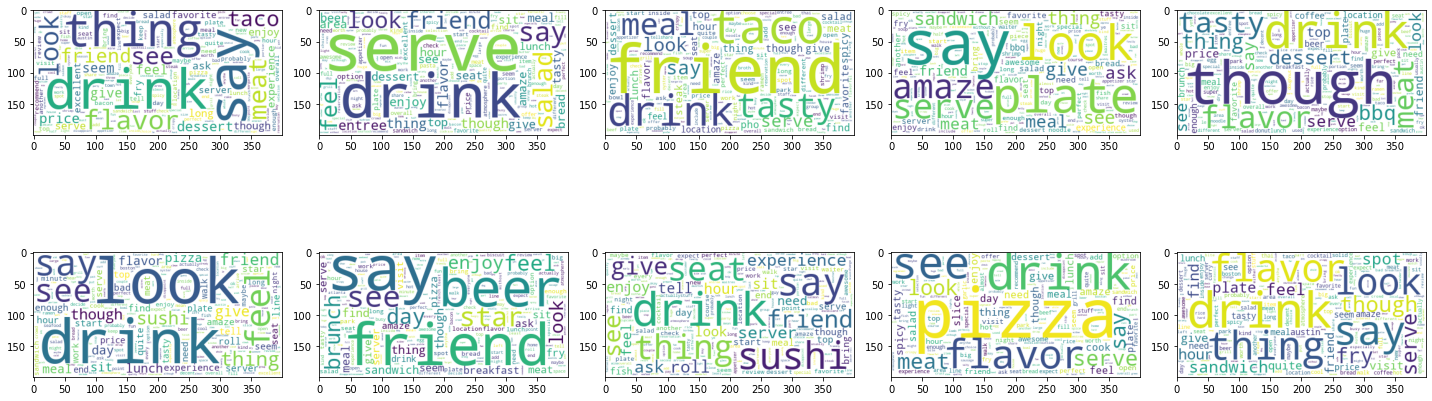

In [117]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
fig, axes = plt.subplots(2, 5, figsize = (20, 8))
for i in range(num_topics):
    ax = axes[i//5, i%5]
    text_to_plot = text_with_topic_proportion[text_with_topic_proportion['majorTopic'] == i]['text_processed'].to_list()
    text_to_plot = [i for l in text_to_plot for i in l]
    wordcloud.generate(" ".join(text_to_plot))
    ax.imshow(wordcloud)
plt.tight_layout()
plt.show()

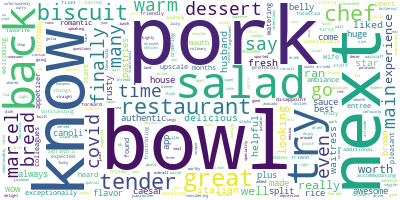

In [73]:
comment_3 = comment2[maxValueIndexObj==3]
data3 = comment_3.text_processed.values.tolist()

import numpy as np
a = list(np.concatenate(data_words3).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

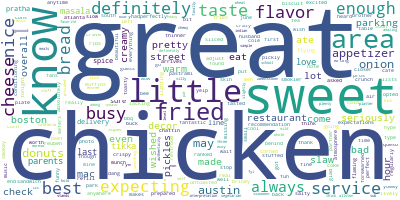

In [74]:
comment_4 = comment2[maxValueIndexObj==4]
data4 = comment_4.text_processed.values.tolist()
data_words4 = list(sent_to_words(data4))
# remove stop words
data_words4 = remove_stopwords(data_words4)
import numpy as np
a = list(np.concatenate(data_words4).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

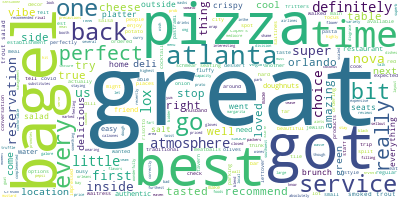

In [75]:
comment_5 = comment2[maxValueIndexObj==5]
data5 = comment_5.text_processed.values.tolist()
data_words5 = list(sent_to_words(data5))
# remove stop words
data_words5 = remove_stopwords(data_words5)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

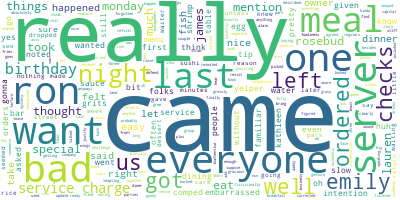

In [76]:
comment_6 = comment2[maxValueIndexObj==6]
data6 = comment_6.text_processed.values.tolist()
data_words6 = list(sent_to_words(data6))
# remove stop words
data_words6 = remove_stopwords(data_words6)
import numpy as np
a = list(np.concatenate(data_words6).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

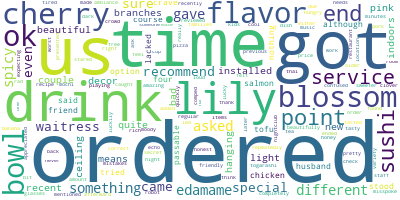

In [78]:
comment_7 = comment2[maxValueIndexObj==7]
data7 = comment_7.text_processed.values.tolist()
data_words7 = list(sent_to_words(data7))
# remove stop words
data_words7 = remove_stopwords(data_words7)
import numpy as np
a = list(np.concatenate(data_words7).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

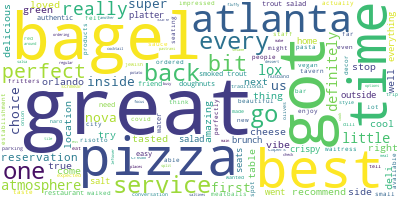

In [79]:
comment_8 = comment2[maxValueIndexObj==8]
data8 = comment_8.text_processed.values.tolist()
data_words8 = list(sent_to_words(data8))
# remove stop words
data_words8 = remove_stopwords(data_words8)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

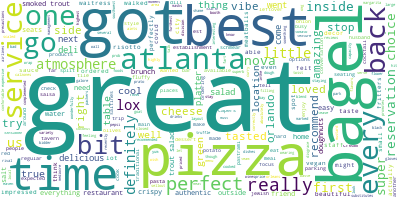

In [80]:
comment_9 = comment2[maxValueIndexObj==9]
data9 = comment_9.text_processed.values.tolist()
data_words9 = list(sent_to_words(data9))
# remove stop words
data_words9 = remove_stopwords(data_words9)
import numpy as np
a = list(np.concatenate(data_words5).flat)

long_string = ','.join(a)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()